In [139]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import seaborn as sns 
import plotly.express as px 
import re 
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from wordcloud import WordCloud, STOPWORDS
from nltk.tokenize import word_tokenize

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import RidgeClassifier
from xgboost import XGBClassifier
from sklearn.neural_network import MLPClassifier
from catboost import CatBoostClassifier
from sklearn.model_selection import GridSearchCV

import category_encoders as ce 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,confusion_matrix,classification_report,roc_auc_score,roc_curve,auc 

import warnings
warnings.filterwarnings('ignore')


In [140]:
data_train=pd.read_csv('train.csv')
data_test=pd.read_csv('test.csv')
data_train.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [141]:
data_test.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [142]:
data_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [143]:
data_train.target.value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

In [144]:
data_train.drop(columns=['keyword','location'],axis=1,inplace=True)
data_test.drop(columns=['keyword','location'],axis=1,inplace=True)

In [145]:
data_train.head()

,id,text,target
0,1,Our Deeds are the Reason of this #earthquake M...,1
1,4,Forest fire near La Ronge Sask. Canada,1
2,5,All residents asked to 'shelter in place' are ...,1
3,6,"13,000 people receive #wildfires evacuation or...",1
4,7,Just got sent this photo from Ruby #Alaska as ...,1


In [146]:
data_train.drop_duplicates('text',keep='first',inplace=True)

In [147]:
data_train.target.value_counts()

target
0    4305
1    3198
Name: count, dtype: int64

In [148]:
data_train['text'].shape

(7503,)

In [149]:
data_train.isnull().sum()

id        0
text      0
target    0
dtype: int64

In [150]:
data_train.drop(columns=['id'],axis=1,inplace=True)
data_test.drop(columns=['id'],axis=1,inplace=True)
data_train.head()

,text,target
0,Our Deeds are the Reason of this #earthquake M...,1
1,Forest fire near La Ronge Sask. Canada,1
2,All residents asked to 'shelter in place' are ...,1
3,"13,000 people receive #wildfires evacuation or...",1
4,Just got sent this photo from Ruby #Alaska as ...,1


In [151]:
data_test.head()

,text
0,Just happened a terrible car crash
1,"Heard about #earthquake is different cities, s..."
2,"there is a forest fire at spot pond, geese are..."
3,Apocalypse lighting. #Spokane #wildfires
4,Typhoon Soudelor kills 28 in China and Taiwan


In [152]:
#preprocess data 

def preprocess_text(text):
    #remove URLs
    text=re.sub(r'http\S+', '', text)
    text=re.sub(r'\[|\]', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('\d', '', text)
    text = re.sub('[“”…]', '', text)
    text = re.sub('\n', '', text)
    text = re.sub('\s+', ' ', text)
    text = re.sub('[^A-Za-z0-9\s]', '', text)
     
    #Tokenization
    tokens=word_tokenize(text)
    
    #Lowercasing 
    tokens_lower=[token.lower() for token in tokens]
    
    #Removing punctuation 
    tokens_no_punct=[token for token in tokens_lower if token not in string.punctuation ]
    
    #Removing stopwords
    stop_words=set(stopwords.words('english'))
    tokens_no_stopwords=[token for token in tokens_no_punct if token not in stop_words]
    
    #stemming 
    porter=PorterStemmer()
    tokens_stemmed=[porter.stem(token) for token in tokens_no_stopwords]
    
    #lemmatization
    lemmatizer=WordNetLemmatizer()
    tokens_lemmatized=[lemmatizer.lemmatize(token) for token in tokens_no_stopwords]
    
    return tokens_lemmatized


In [153]:
data_train['text']=data_train['text'].apply(lambda text: preprocess_text(text))
data_train['text']=data_train['text'].apply(lambda x:' '.join(x))

In [154]:
data_test['text']=data_test['text'].apply(lambda text: preprocess_text(text))
data_test['text']=data_test['text'].apply(lambda x:' '.join(x))

In [155]:
data_train.head()

,text,target
0,deed reason earthquake may allah forgive u,1
1,forest fire near la ronge sask canada,1
2,resident asked shelter place notified officer ...,1
3,people receive wildfire evacuation order calif...,1
4,got sent photo ruby alaska smoke wildfire pour...,1


In [156]:
data_test.head()


,text
0,happened terrible car crash
1,heard earthquake different city stay safe ever...
2,forest fire spot pond goose fleeing across str...
3,apocalypse lighting spokane wildfire
4,typhoon soudelor kill china taiwan


In [176]:
from sklearn.feature_extraction.text import TfidfVectorizer
tfidf = TfidfVectorizer(max_features=5000, stop_words='english')
X = tfidf.fit_transform(data_train['text'])

In [181]:
X_train,X_valid,y_train,y_valid=train_test_split(X,data_train['target'],train_size=0.8,random_state=42)

In [182]:
print("X_train shape:",X_train.shape)
print("y_train shape:",y_train.shape)
print("X_train datatype:",X_train.dtype)
print("y_train datatype:",y_train.dtype)

X_train shape: (6002, 5000)
y_train shape: (6002,)
X_train datatype: float64
y_train datatype: int64


In [183]:
print("X_valid shape:",X_valid.shape)
print("y_valid shape:",y_valid.shape)
print("X_valid datatype:",X_valid.dtype)
print("y_valid datatype:",y_valid.dtype)

X_valid shape: (1501, 5000)
y_valid shape: (1501,)
X_valid datatype: float64
y_valid datatype: int64


# LOGISTIC REGRESSION

In [184]:
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

In [186]:
from sklearn.metrics import f1_score
y_pred = model.predict(X_valid)
print(classification_report(y_valid, y_pred))
print('F1 Score:', f1_score(y_valid, y_pred))

              precision    recall  f1-score   support

           0       0.79      0.90      0.84       874
           1       0.83      0.67      0.74       627

    accuracy                           0.80      1501
   macro avg       0.81      0.78      0.79      1501
weighted avg       0.81      0.80      0.80      1501

F1 Score: 0.7393617021276596
accuracy: 0.8041305796135909


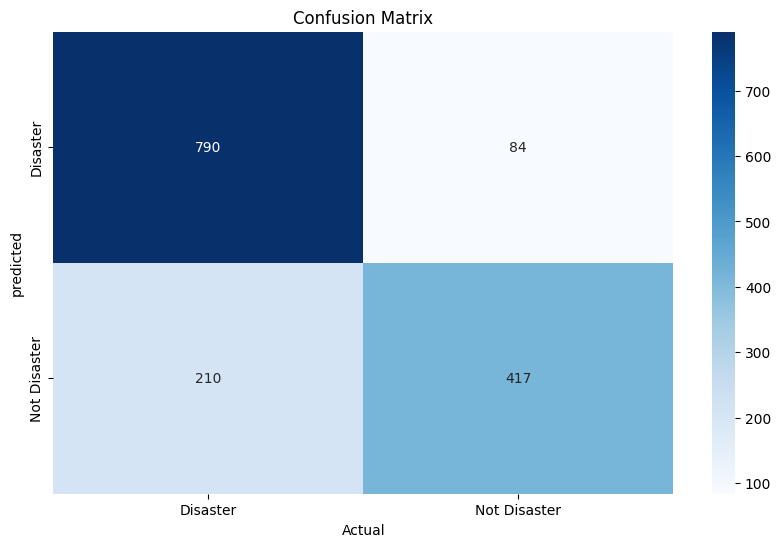

In [189]:
cm = confusion_matrix(y_valid, y_pred)
plt.figure(figsize=(10, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=[ 'Disaster','Not Disaster'], yticklabels=['Disaster','Not Disaster'])
plt.xlabel('Actual')
plt.ylabel('predicted')
plt.title('Confusion Matrix')
plt.show()

In [192]:

X_test = tfidf.transform(data_test['text'])
data_test['target'] = model.predict(X_test)

In [194]:
test_data_new=pd.read_csv('test.csv')
test_data_new.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [196]:
print(data_test['target'].shape)
print(test_data_new.shape)

(3263,)
(3263, 4)


In [197]:
data_test['id']=test_data_new['id']

In [198]:
print(data_test)

                                                   text  target     id
0                           happened terrible car crash       1      0
1     heard earthquake different city stay safe ever...       1      2
2     forest fire spot pond goose fleeing across str...       1      3
3                  apocalypse lighting spokane wildfire       1      9
4                    typhoon soudelor kill china taiwan       1     11
...                                                 ...     ...    ...
3258  earthquake safety los angeles safety fastener ...       1  10861
3259  storm ri worse last hurricane cityampothers ha...       1  10865
3260                      green line derailment chicago       1  10868
3261            meg issue hazardous weather outlook hwo       1  10874
3262  cityofcalgary activated municipal emergency pl...       1  10875

[3263 rows x 3 columns]


In [199]:
data_test[['id', 'target']].to_csv('submission.csv', index=False)
submission_data=pd.read_csv("submission.csv")
submission_data.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1
